<a href="https://colab.research.google.com/github/Ekimwatan/NDVI-forcasting-Sugarcane-plantations/blob/main/NDVI_forcasting_of_sugarcane_plantations.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##An analysis of NDVI values of the prosperine area in Queensland from satellite images of sugarcane plantations



In [ ]:
#install packages
!pip install earthengine-api
!pip install ipygee
!pip install sktime

In [ ]:
import ee
ee.Authenticate()
ee.Initialize()

To authorize access needed by Earth Engine, open the following URL in a web browser and follow the instructions. If the web browser does not start automatically, please manually browse the URL below.

    https://accounts.google.com/o/oauth2/auth?client_id=517222506229-vsmmajv00ul0bs7p89v5m89qs8eb9359.apps.googleusercontent.com&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fearthengine+https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdevstorage.full_control&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&response_type=code&code_challenge=wijHQeb2BCR6I8K1LXgGekFqxrgUHh_DBqu-3ddLTwM&code_challenge_method=S256

The authorization workflow will generate a code, which you should paste in the box below. 
Enter verification code: 4/1AfDhmrhZp5kDybEqqek2dKq1Tq2xDssjQt5fHt595T0sAJ-N2VZh5q0ud-8

Successfully saved authorization token.


In [ ]:
#Import dependancies
import pandas as pd
from ipygee import *
import folium
from folium import plugins
from IPython.display import Image



Area of interest= Prosperine Area queensland

In [ ]:
AOI = ee.Geometry.Polygon([[[148.69443975983441, -20.812410418698178],
                            [148.743334561267119, -20.81200398167918],
                            [148.743620498264306, -20.858263265061037],
                            [148.694725696831597, -20.858669702080036]]])

In [ ]:
startdate = ee.Date.fromYMD(2020, 7, 1);
enddate = ee.Date.fromYMD(2020, 10, 30);

collection = ee.ImageCollection("COPERNICUS/S2").filterDate(startdate, enddate).filterBounds(AOI).filterMetadata('CLOUDY_PIXEL_PERCENTAGE', 'less_than', 0.1);


In [ ]:
S2 = collection.median().clip(AOI).divide(10000)
vis_params = {'min':0, 'max':0.4, 'bands':['B4', 'B3', 'B2']}

##NDVI

In [ ]:
NDVI = S2.normalizedDifference(['B8', 'B4']).rename('NDVI')
ndvi_params = {'min': 0, 'max': 0.8, 'palette': ['red', 'yellow','green']}

In [ ]:
basemaps = {
    'Google Satellite': folium.TileLayer(
        tiles = 'https://mt1.google.com/vt/lyrs=s&x={x}&y={y}&z={z}',
        attr = 'Google',
        name = 'Google Satellite',
        overlay = True,
        control = True
    ),
    'Google Terrain': folium.TileLayer(
        tiles = 'https://mt1.google.com/vt/lyrs=p&x={x}&y={y}&z={z}',
        attr = 'Google',
        name = 'Google Terrain',
        overlay = True,
        control = True
    )}

In [ ]:
def add_ee_layer(self, ee_object, vis_params, name):
    
    try:    
        # display ee.Image()
        if isinstance(ee_object, ee.image.Image):    
            map_id_dict = ee.Image(ee_object).getMapId(vis_params)
            folium.raster_layers.TileLayer(
            tiles = map_id_dict['tile_fetcher'].url_format,
            attr = 'Google Earth Engine',
            name = name,
            overlay = True,
            control = True
            ).add_to(self)
        # display ee.ImageCollection()
        elif isinstance(ee_object, ee.imagecollection.ImageCollection):    
            ee_object_new = ee_object.mosaic()
            map_id_dict = ee.Image(ee_object_new).getMapId(vis_params)
            folium.raster_layers.TileLayer(
            tiles = map_id_dict['tile_fetcher'].url_format,
            attr = 'Google Earth Engine',
            name = name,
            overlay = True,
            control = True
            ).add_to(self)
        # display ee.Geometry()
        elif isinstance(ee_object, ee.geometry.Geometry):    
            folium.GeoJson(
            data = ee_object.getInfo(),
            name = name,
            overlay = True,
            control = True
        ).add_to(self)
        # display ee.FeatureCollection()
        elif isinstance(ee_object, ee.featurecollection.FeatureCollection):  
            ee_object_new = ee.Image().paint(ee_object, 0, 2)
            map_id_dict = ee.Image(ee_object_new).getMapId(vis_params)
            folium.raster_layers.TileLayer(
            tiles = map_id_dict['tile_fetcher'].url_format,
            attr = 'Google Earth Engine',
            name = name,
            overlay = True,
            control = True
        ).add_to(self)
    
    except:
        print("Could not display {}".format(name))
    
# Add EE drawing method to folium.
folium.Map.add_ee_layer = add_ee_layer

In [ ]:
map_1 = folium.Map(location=[-20.858669702080036, 148.694725696831597,], zoom_start=12)

basemaps['Google Terrain'].add_to(map_1)

map_1.add_ee_layer(S2, vis_params, 'Sentinel_2')
map_1.add_ee_layer(NDVI, ndvi_params, 'NDVI')
map_1.add_child(folium.LayerControl())

display(map_1)



Gather NDVI values

In [ ]:
startDate = ee.Date.fromYMD(2015,1,1)
endDate = ee.Date.fromYMD(2020,10,1)

In [ ]:
s2_prosperine = ee.ImageCollection("COPERNICUS/S2").filterDate(startDate, endDate).filterBounds(AOI).filterMetadata('CLOUDY_PIXEL_PERCENTAGE', 'less_than', 1)
NDVI_prosperine = s2_prosperine.map(lambda image: image.normalizedDifference(['B8', 'B4']).rename('NDVI').copyProperties(image, ['system:time_start']))

In [ ]:
ndvi = chart.Image.series(**{'imageCollection': NDVI_prosperine,
                             'region':AOI,
                             'reducer':ee.Reducer.mean(),
                             'scale':20,
                             'xProperty':'system:time_start'})

In [ ]:
ndvi.renderWidget(width='50%')

HTML(value='<embed src=data:image/svg+xml;charset=utf-8;base64,PD94bWwgdmVyc2lvbj0nMS4wJyBlbmNvZGluZz0ndXRmLTg…

create dataframe from chart with ndvi values

In [ ]:
ndvi_df = ndvi.dataframe
ndvi_df.head(10)

,NDVI
2016-01-07 00:22:45.888,0.511241
2016-01-07 00:22:45.888,0.511241
2016-01-07 00:22:45.888,0.511241
2016-01-07 00:22:45.888,0.511241
2016-05-26 00:21:11.000,0.456461
2016-05-26 00:21:11.460,0.456461
2016-06-05 00:21:10.000,0.602185
2016-06-05 00:21:10.000,0.602179
2016-06-05 00:21:10.458,0.602185
2016-06-05 00:21:10.458,0.602179


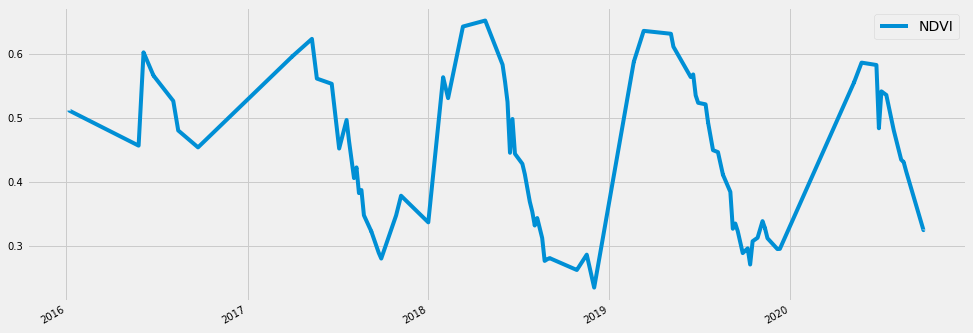

In [ ]:
import matplotlib
import matplotlib.pyplot as plt

from pylab import rcParams
import seaborn as sns


matplotlib.rcParams['axes.labelsize'] = 12
matplotlib.rcParams['xtick.labelsize'] = 10
matplotlib.rcParams['ytick.labelsize'] = 10
matplotlib.rcParams['text.color'] = 'k'
plt.style.use('fivethirtyeight')

ndvi_df.plot(figsize=(15,6))

In [ ]:
ndvi_df.reset_index(inplace=True)
ndvi_df.head()

,index,NDVI
0,2016-01-07 00:22:45.888,0.511241
1,2016-01-07 00:22:45.888,0.511241
2,2016-01-07 00:22:45.888,0.511241
3,2016-01-07 00:22:45.888,0.511241
4,2016-05-26 00:21:11.000,0.456461


In [ ]:
ndvi_df['index'] = ndvi_df['index'].dt.date

In [ ]:
ndvi_df['index'] = pd.to_datetime(ndvi_df['index'], format='%Y-%m')
ndvi_df = ndvi_df.set_index('index')

Remove duplicates from the index/date column to ensure we have only one ndvi reading per day

In [ ]:
index = ndvi_df.index
is_duplicate = index.duplicated(keep='first')
not_duplicate = ~is_duplicate
ndvi_new = ndvi_df[not_duplicate]

In [ ]:
ndvi_new.head()

,NDVI
index,
2016-01-07,0.511241
2016-05-26,0.456461
2016-06-05,0.602185
2016-06-25,0.565930
2016-07-25,0.536101


Interpolating data so we have readings for all days. We will use a linear method of interpolation. This makes it possible for turning it into a time series problem

                NDVI
index               
2016-01-07  0.511241
2016-01-08  0.510850
2016-01-09  0.510459
2016-01-10  0.510068
2016-01-11  0.509676


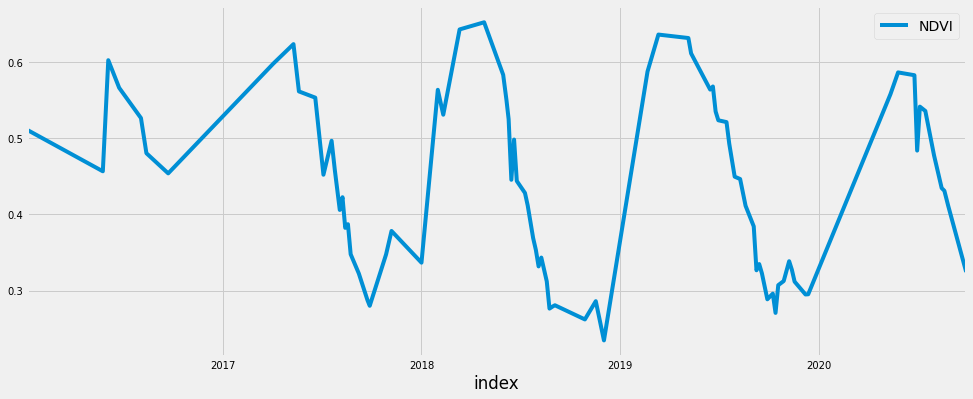

In [ ]:
upsampled = ndvi_new.resample('D')
interpolated = upsampled.interpolate(method='linear')

print(interpolated.head())

interpolated.plot(figsize=(15,6))

##Problem statement: Given previous 2 week NDVI values of Sugarcane plantations, can we predict the next 1 week NDVI values and use it as a measure of crop health/condition?

###Converting data to a time_series favourable format

In [ ]:
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
	"""
	Frame a time series as a supervised learning dataset.
	Arguments:
		data: Sequence of observations as a list or NumPy array.
		n_in: Number of lag observations as input (X).
		n_out: Number of observations as output (y).
		dropnan: Boolean whether or not to drop rows with NaN values.
	Returns:
		Pandas DataFrame of series framed for supervised learning.
	"""
	n_vars = 1 if type(data) is list else data.shape[1]
	df = pd.DataFrame(data)
	cols, names = list(), list()
	# input sequence (t-n, ... t-1)
	for i in range(n_in, 0, -1):
		cols.append(df.shift(i))
		names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
	# forecast sequence (t, t+1, ... t+n)
	for i in range(0, n_out):
		cols.append(df.shift(-i))
		if i == 0:
			names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
		else:
			names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
	# put it all together
	agg = pd.concat(cols, axis=1)
	agg.columns = names
	# drop rows with NaN values
	if dropnan:
		agg.dropna(inplace=True)
	return agg

In [ ]:
values = interpolated.values

final_df = series_to_supervised(values, 14, 1)

final_df.head(14)

,var1(t-14),var1(t-13),var1(t-12),var1(t-11),var1(t-10),var1(t-9),var1(t-8),var1(t-7),var1(t-6),var1(t-5),var1(t-4),var1(t-3),var1(t-2),var1(t-1),var1(t)
14,0.511241,0.510850,0.510459,0.510068,0.509676,0.509285,0.508894,0.508502,0.508111,0.507720,0.507329,0.506937,0.506546,0.506155,0.505763
15,0.510850,0.510459,0.510068,0.509676,0.509285,0.508894,0.508502,0.508111,0.507720,0.507329,0.506937,0.506546,0.506155,0.505763,0.505372
16,0.510459,0.510068,0.509676,0.509285,0.508894,0.508502,0.508111,0.507720,0.507329,0.506937,0.506546,0.506155,0.505763,0.505372,0.504981
17,0.510068,0.509676,0.509285,0.508894,0.508502,0.508111,0.507720,0.507329,0.506937,0.506546,0.506155,0.505763,0.505372,0.504981,0.504590
18,0.509676,0.509285,0.508894,0.508502,0.508111,0.507720,0.507329,0.506937,0.506546,0.506155,0.505763,0.505372,0.504981,0.504590,0.504198
19,0.509285,0.508894,0.508502,0.508111,0.507720,0.507329,0.506937,0.506546,0.506155,0.505763,0.505372,0.504981,0.504590,0.504198,0.503807
20,0.508894,0.508502,0.508111,0.507720,0.507329,0.506937,0.506546,0.506155,0.505763,0.505372,0.504981,0.504590,0.504198,0.503807,0.503416
21,0.508502,0.508111,0.507720,0.507329,0.506937,0.506546,0.506155,0.505763,0.505372,0.504981,0.504590,0.504198,0.503807,0.503416,0.503024
22,0.508111,0.507720,0.507329,0.506937,0.506546,0.506155,0.505763,0.505372,0.504981,0.504590,0.504198,0.503807,0.503416,0.503024,0.502633
23,0.507720,0.507329,0.506937,0.506546,0.506155,0.505763,0.505372,0.504981,0.504590,0.504198,0.503807,0.503416,0.503024,0.502633,0.502242


###Splitting dataset into train and test
###I use the first 4 years for training and 2020 for test

*   List item
*   List item



In [ ]:
final_df.shape

(1712, 15)

In [ ]:
#first 4 years is 365*4 days
values = final_df.values
train = values[:1460, :]
test = values[1460:, :]

train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]

###Defining the LSTM model
#####LSTM models expect input in 3D ie [samples, timesteps, features]

In [ ]:
#Reshaping input data as 3D

train_X = train_X.reshape(train_X.shape[0], 1, train_X.shape[1])
test_X = test_X.reshape(test_X.shape[0], 1, test_X.shape[1])

print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

(1460, 1, 14) (1460,) (252, 1, 14) (252,)


In [ ]:
import keras
from keras import layers, models, Sequential


def create_model():
  model = Sequential()
  model.add(layers.LSTM(50, input_shape=(train_X.shape[1], train_X.shape[2])))
  model.add(layers.Dense(1))
  model.compile(loss='mae', optimizer='adam')
  return model


Epoch 1/100
49/49 - 0s - loss: 0.1463 - val_loss: 0.0239
Epoch 2/100
49/49 - 0s - loss: 0.0206 - val_loss: 0.0213
Epoch 3/100
49/49 - 0s - loss: 0.0189 - val_loss: 0.0437
Epoch 4/100
49/49 - 0s - loss: 0.0209 - val_loss: 0.0210
Epoch 5/100
49/49 - 0s - loss: 0.0182 - val_loss: 0.0186
Epoch 6/100
49/49 - 0s - loss: 0.0174 - val_loss: 0.0192
Epoch 7/100
49/49 - 0s - loss: 0.0163 - val_loss: 0.0336
Epoch 8/100
49/49 - 0s - loss: 0.0186 - val_loss: 0.0128
Epoch 9/100
49/49 - 0s - loss: 0.0183 - val_loss: 0.0413
Epoch 10/100
49/49 - 0s - loss: 0.0180 - val_loss: 0.0156
Epoch 11/100
49/49 - 0s - loss: 0.0168 - val_loss: 0.0264
Epoch 12/100
49/49 - 0s - loss: 0.0168 - val_loss: 0.0172
Epoch 13/100
49/49 - 0s - loss: 0.0163 - val_loss: 0.0307
Epoch 14/100
49/49 - 0s - loss: 0.0178 - val_loss: 0.0183
Epoch 15/100
49/49 - 0s - loss: 0.0150 - val_loss: 0.0286
Epoch 16/100
49/49 - 0s - loss: 0.0171 - val_loss: 0.0115
Epoch 17/100
49/49 - 0s - loss: 0.0166 - val_loss: 0.0382
Epoch 18/100
49/49 - 0s

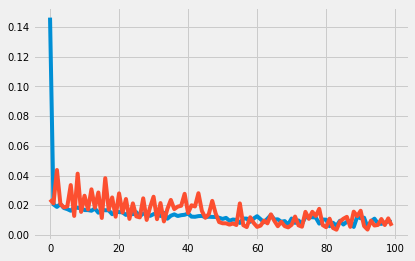

In [ ]:
lstm_model = create_model()

#fit model
history = lstm_model.fit(train_X, train_y, epochs=100, batch_size=30, validation_data = (test_X, test_y), verbose=2, shuffle=False)

plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')

In [ ]:
#Model Evaluation
from sklearn.metrics import mean_squared_error

yhat = lstm_model.predict(test_X)
test_X = test_X.reshape(test_X.shape[0], test_X.shape[2])

mse = mean_squared_error(test_y, yhat)

print(f"The MSE is {mse}")

The MSE is 9.134140947716878e-05


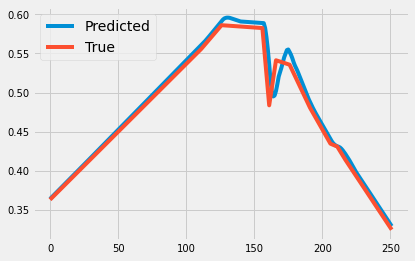

In [ ]:
plt.plot(range(len(test_y)), yhat, label='Predicted')
plt.plot(range(len(test_y)), test_y, label='True')
plt.legend()